# Polystyrene Mastercurve Analysis

Sweep GM modes on polystyrene mastercurve.

**Data:** examples/data/pyRheo/polystyrene/master_curve_ps_oscillation_data.csv

In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fractional_maxwell_model import FractionalMaxwellModel
from rheojax.models.generalized_maxwell import GeneralizedMaxwell
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)
import arviz as az


INFO:2025-12-06 20:03:59,796:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Loading rheojax version 0.4.0


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


Found 'auto' as default backend, checking available backends


Matplotlib is available, defining as default backend


arviz_base available, exposing its functions as part of arviz.preview


arviz_stats available, exposing its functions as part of arviz.preview


arviz_plots available, exposing its functions as part of arviz.preview


## Load polystyrene mastercurve

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'pyRheo' / 'polystyrene'
df = pd.read_csv(DATA_DIR / 'master_curve_ps_oscillation_data.csv')
omega = df['Angular Frequency'].to_numpy()
Gp = df['Storage Modulus'].to_numpy()
Gpp = df['Loss Modulus'].to_numpy()
G_star = Gp + 1j*Gpp


## Sweep GM modes

In [4]:
records = []
for modes in [2, 4, 6, 8]:
    model = GeneralizedMaxwell(n_modes=modes, modulus_type='tensile')
    model.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True)
    pred = model.predict(omega)
    if pred.ndim == 2:
        pred = pred[:,0] + 1j*pred[:,1]
    r2 = r2_complex(G_star, pred)
    records.append({'n_modes': modes, 'r2': r2})
pd.DataFrame(records)


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.918888s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=47 | final_cost=9.735035e+11 | time=0.919s | final_gradient_norm=692647729.9577972


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.241007s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=47 | final_cost=9.735035e+11 | time=0.241s | final_gradient_norm=692647729.9577972


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.537529s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=3.688319e+12 | time=0.538s | final_gradient_norm=6.281065605268301e+19


Element minimization: early termination at n_modes=1 (R²=0.934481 < threshold=0.974060)


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.127523s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=50 | final_cost=1.057424e+11 | time=1.128s | final_gradient_norm=67696131.21140718


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.319438s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=50 | final_cost=1.057424e+11 | time=0.319s | final_gradient_norm=67696131.21140718


Starting least squares optimization | {'method': 'trf', 'n_params': 7, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.749454s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=73 | final_cost=3.547676e+11 | time=0.749s | final_gradient_norm=3.130545506864798e+18


Element minimization: early termination at n_modes=3 (R²=0.993698 < threshold=0.997182)


Starting least squares optimization | {'method': 'trf', 'n_params': 13, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.173384s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=48 | final_cost=1.880866e+10 | time=1.173s | final_gradient_norm=2.5879054481782115e+17


Starting least squares optimization | {'method': 'trf', 'n_params': 13, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.437756s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=48 | final_cost=1.880866e+10 | time=0.438s | final_gradient_norm=2.5879054481782115e+17


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.104116s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=31 | final_cost=3.937492e+10 | time=1.104s | final_gradient_norm=2.0200867654136484e+16


Element minimization: early termination at n_modes=5 (R²=0.999301 < threshold=0.999499)


Starting least squares optimization | {'method': 'trf', 'n_params': 17, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.105047s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=23 | final_cost=1.123478e+10 | time=1.105s | final_gradient_norm=6.379665019226636e+20


Starting least squares optimization | {'method': 'trf', 'n_params': 17, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.339310s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=23 | final_cost=1.123478e+10 | time=0.339s | final_gradient_norm=6.379665019226636e+20


Starting least squares optimization | {'method': 'trf', 'n_params': 15, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.025095s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=1 | final_cost=8.424502e+10 | time=1.025s | final_gradient_norm=5.122000074224201e+21


Element minimization: early termination at n_modes=7 (R²=0.998503 < threshold=0.999701)


,n_modes,r2
0,2,0.982704
1,4,0.998121
2,6,0.999666
3,8,0.999800


## Plot best vs data

Starting least squares optimization | {'method': 'trf', 'n_params': 17, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.356010s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=23 | final_cost=1.123478e+10 | time=0.356s | final_gradient_norm=6.379665019226636e+20


Starting least squares optimization | {'method': 'trf', 'n_params': 17, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.351124s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=23 | final_cost=1.123478e+10 | time=0.351s | final_gradient_norm=6.379665019226636e+20


Starting least squares optimization | {'method': 'trf', 'n_params': 15, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.350800s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=1 | final_cost=8.424502e+10 | time=0.351s | final_gradient_norm=5.122000074224201e+21


Element minimization: early termination at n_modes=7 (R²=0.998503 < threshold=0.999701)


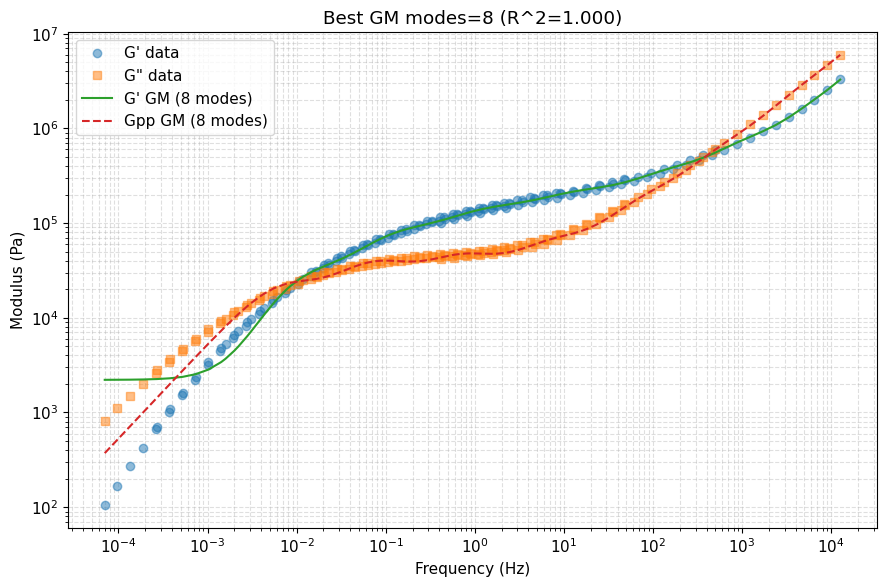

In [5]:
best = max(records, key=lambda x: x['r2'])
best_model = GeneralizedMaxwell(n_modes=best['n_modes'], modulus_type='tensile')
best_model.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True)
best_pred = best_model.predict(omega)
if best_pred.ndim == 2:
    best_pred = best_pred[:,0] + 1j*best_pred[:,1]
freq_hz = omega/(2*np.pi)

fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(freq_hz, np.real(G_star), 'o', label="G' data", alpha=0.5)
ax.loglog(freq_hz, np.imag(G_star), 's', label='G" data', alpha=0.5)
ax.loglog(freq_hz, np.real(best_pred), '-', label=f"G' GM ({best['n_modes']} modes)")
ax.loglog(freq_hz, np.imag(best_pred), '--', label=f"Gpp GM ({best['n_modes']} modes)")
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Modulus (Pa)')
ax.set_title(f"Best GM modes={best['n_modes']} (R^2={best['r2']:.3f})")
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

Starting least squares optimization | {'method': 'trf', 'n_params': 17, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.403902s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=23 | final_cost=1.123478e+10 | time=0.404s | final_gradient_norm=6.379665019226636e+20


Starting least squares optimization | {'method': 'trf', 'n_params': 17, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.359213s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=23 | final_cost=1.123478e+10 | time=0.359s | final_gradient_norm=6.379665019226636e+20


Starting least squares optimization | {'method': 'trf', 'n_params': 15, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.265404s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=1 | final_cost=8.424502e+10 | time=0.265s | final_gradient_norm=5.122000074224201e+21


Element minimization: early termination at n_modes=7 (R²=0.998503 < threshold=0.999701)


Starting least squares optimization | {'method': 'trf', 'n_params': 17, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.353981s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=23 | final_cost=1.123478e+10 | time=0.354s | final_gradient_norm=6.379665019226636e+20


Starting least squares optimization | {'method': 'trf', 'n_params': 17, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.357237s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=23 | final_cost=1.123478e+10 | time=0.357s | final_gradient_norm=6.379665019226636e+20


Starting least squares optimization | {'method': 'trf', 'n_params': 15, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.268186s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=1 | final_cost=8.424502e+10 | time=0.268s | final_gradient_norm=5.122000074224201e+21


Element minimization: early termination at n_modes=7 (R²=0.998503 < threshold=0.999701)


Model ranking (R²): [('model', 1.0), ('best_model', 1.0)]


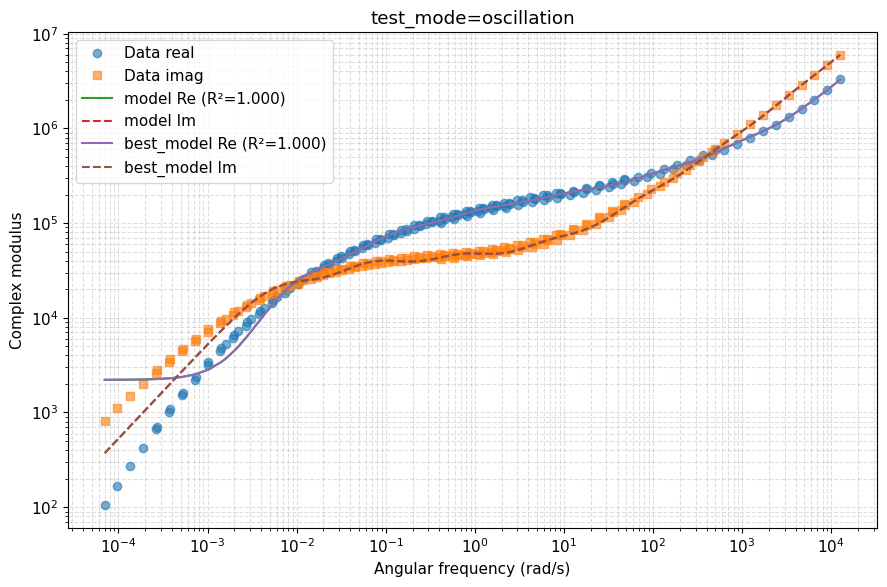

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:01<1:34:59,  1.43s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 25/4000 [00:01<03:00, 22.01it/s, 1023 steps of size 1.22e-02. acc. prob=0.71]

warmup:   1%|          | 37/4000 [00:01<02:10, 30.42it/s, 1023 steps of size 1.25e-02. acc. prob=0.73]

warmup:   1%|          | 47/4000 [00:01<01:40, 39.19it/s, 1023 steps of size 5.53e-03. acc. prob=0.73]

warmup:   1%|▏         | 57/4000 [00:01<01:29, 44.02it/s, 1023 steps of size 1.54e-02. acc. prob=0.75]

warmup:   2%|▏         | 66/4000 [00:02<01:20, 48.69it/s, 15 steps of size 5.53e-03. acc. prob=0.75]  

warmup:   2%|▏         | 74/4000 [00:02<01:15, 52.02it/s, 511 steps of size 1.88e-02. acc. prob=0.76]

warmup:   2%|▏         | 82/4000 [00:02<01:09, 56.31it/s, 1023 steps of size 1.01e-02. acc. prob=0.76]

warmup:   2%|▏         | 90/4000 [00:02<01:05, 60.12it/s, 511 steps of size 1.42e-02. acc. prob=0.76] 

warmup:   2%|▏         | 98/4000 [00:02<01:02, 62.82it/s, 1023 steps of size 7.11e-03. acc. prob=0.76]

warmup:   3%|▎         | 137/4000 [00:02<00:27, 142.16it/s, 95 steps of size 1.41e-01. acc. prob=0.77]

warmup:   5%|▌         | 219/4000 [00:02<00:11, 316.70it/s, 31 steps of size 2.17e-01. acc. prob=0.78]

warmup:   8%|▊         | 306/4000 [00:02<00:07, 464.89it/s, 127 steps of size 6.69e-02. acc. prob=0.78]

warmup:  10%|█         | 409/4000 [00:02<00:05, 621.09it/s, 15 steps of size 3.07e-01. acc. prob=0.79] 

warmup:  13%|█▎        | 504/4000 [00:03<00:04, 714.21it/s, 7 steps of size 8.16e-02. acc. prob=0.78] 

warmup:  15%|█▌        | 601/4000 [00:03<00:04, 786.73it/s, 15 steps of size 2.45e-01. acc. prob=0.79]

warmup:  18%|█▊        | 716/4000 [00:03<00:03, 891.72it/s, 31 steps of size 1.43e-01. acc. prob=0.79]

warmup:  20%|██        | 818/4000 [00:03<00:03, 928.98it/s, 7 steps of size 1.72e-01. acc. prob=0.79] 

warmup:  23%|██▎       | 932/4000 [00:03<00:03, 991.07it/s, 15 steps of size 2.63e-01. acc. prob=0.79]

sample:  26%|██▌       | 1033/4000 [00:03<00:03, 835.00it/s, 31 steps of size 1.36e-01. acc. prob=0.96]

sample:  28%|██▊       | 1123/4000 [00:03<00:03, 850.77it/s, 31 steps of size 1.36e-01. acc. prob=0.96]

sample:  30%|███       | 1215/4000 [00:03<00:03, 867.32it/s, 31 steps of size 1.36e-01. acc. prob=0.96]

sample:  33%|███▎      | 1308/4000 [00:03<00:03, 882.25it/s, 31 steps of size 1.36e-01. acc. prob=0.96]

sample:  35%|███▌      | 1409/4000 [00:04<00:02, 918.18it/s, 7 steps of size 1.36e-01. acc. prob=0.90] 

sample:  39%|███▊      | 1545/4000 [00:04<00:02, 1043.25it/s, 31 steps of size 1.36e-01. acc. prob=0.72]

sample:  42%|████▏     | 1661/4000 [00:04<00:02, 1074.48it/s, 31 steps of size 1.36e-01. acc. prob=0.63]

sample:  44%|████▍     | 1770/4000 [00:04<00:02, 1021.77it/s, 31 steps of size 1.36e-01. acc. prob=0.67]

sample:  47%|████▋     | 1874/4000 [00:04<00:02, 986.34it/s, 31 steps of size 1.36e-01. acc. prob=0.70] 

sample:  49%|████▉     | 1974/4000 [00:04<00:02, 970.38it/s, 31 steps of size 1.36e-01. acc. prob=0.73]

sample:  52%|█████▏    | 2072/4000 [00:04<00:02, 946.10it/s, 15 steps of size 1.36e-01. acc. prob=0.75]

sample:  54%|█████▍    | 2168/4000 [00:04<00:01, 931.67it/s, 31 steps of size 1.36e-01. acc. prob=0.77]

sample:  57%|█████▋    | 2262/4000 [00:04<00:01, 928.40it/s, 31 steps of size 1.36e-01. acc. prob=0.78]

sample:  59%|█████▉    | 2356/4000 [00:05<00:01, 929.90it/s, 31 steps of size 1.36e-01. acc. prob=0.79]

sample:  61%|██████▏   | 2450/4000 [00:05<00:01, 914.94it/s, 31 steps of size 1.36e-01. acc. prob=0.80]

sample:  64%|██████▎   | 2543/4000 [00:05<00:01, 917.99it/s, 31 steps of size 1.36e-01. acc. prob=0.81]

sample:  66%|██████▌   | 2635/4000 [00:05<00:01, 916.60it/s, 31 steps of size 1.36e-01. acc. prob=0.81]

sample:  68%|██████▊   | 2727/4000 [00:05<00:01, 907.99it/s, 31 steps of size 1.36e-01. acc. prob=0.82]

sample:  70%|███████   | 2819/4000 [00:05<00:01, 909.78it/s, 31 steps of size 1.36e-01. acc. prob=0.83]

sample:  73%|███████▎  | 2911/4000 [00:05<00:01, 904.42it/s, 31 steps of size 1.36e-01. acc. prob=0.83]

sample:  75%|███████▌  | 3002/4000 [00:05<00:01, 904.62it/s, 31 steps of size 1.36e-01. acc. prob=0.84]

sample:  77%|███████▋  | 3093/4000 [00:05<00:01, 901.49it/s, 31 steps of size 1.36e-01. acc. prob=0.84]

sample:  80%|███████▉  | 3184/4000 [00:05<00:00, 901.10it/s, 31 steps of size 1.36e-01. acc. prob=0.85]

sample:  82%|████████▏ | 3275/4000 [00:06<00:00, 903.27it/s, 31 steps of size 1.36e-01. acc. prob=0.85]

sample:  84%|████████▍ | 3367/4000 [00:06<00:00, 908.19it/s, 31 steps of size 1.36e-01. acc. prob=0.86]

sample:  86%|████████▋ | 3458/4000 [00:06<00:00, 906.28it/s, 31 steps of size 1.36e-01. acc. prob=0.86]

sample:  89%|████████▊ | 3549/4000 [00:06<00:00, 901.39it/s, 31 steps of size 1.36e-01. acc. prob=0.86]

sample:  91%|█████████ | 3640/4000 [00:06<00:00, 903.30it/s, 31 steps of size 1.36e-01. acc. prob=0.87]

sample:  93%|█████████▎| 3731/4000 [00:06<00:00, 890.53it/s, 31 steps of size 1.36e-01. acc. prob=0.87]

sample:  96%|█████████▌| 3821/4000 [00:06<00:00, 888.97it/s, 31 steps of size 1.36e-01. acc. prob=0.87]

sample:  98%|█████████▊| 3911/4000 [00:06<00:00, 890.03it/s, 31 steps of size 1.36e-01. acc. prob=0.87]

sample: 100%|██████████| 4000/4000 [00:06<00:00, 583.02it/s, 31 steps of size 1.36e-01. acc. prob=0.88]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 20/4000 [00:00<00:22, 174.97it/s, 1023 steps of size 1.70e-02. acc. prob=0.69]

warmup:   1%|          | 38/4000 [00:00<00:40, 97.05it/s, 15 steps of size 3.52e-03. acc. prob=0.72]   

warmup:   1%|▏         | 50/4000 [00:00<00:44, 87.80it/s, 511 steps of size 1.83e-02. acc. prob=0.75]

warmup:   2%|▏         | 60/4000 [00:00<00:44, 87.67it/s, 231 steps of size 4.12e-03. acc. prob=0.74]

warmup:   2%|▏         | 70/4000 [00:00<00:47, 83.31it/s, 511 steps of size 1.38e-02. acc. prob=0.76]

warmup:   2%|▏         | 79/4000 [00:00<00:46, 84.86it/s, 511 steps of size 8.12e-03. acc. prob=0.75]

warmup:   2%|▏         | 89/4000 [00:00<00:44, 87.58it/s, 511 steps of size 1.54e-02. acc. prob=0.76]

warmup:   2%|▏         | 98/4000 [00:01<00:46, 84.66it/s, 1023 steps of size 7.06e-03. acc. prob=0.76]

warmup:   3%|▎         | 136/4000 [00:01<00:23, 164.84it/s, 127 steps of size 9.90e-02. acc. prob=0.77]

warmup:   5%|▌         | 204/4000 [00:01<00:12, 308.66it/s, 63 steps of size 1.08e-01. acc. prob=0.78] 

warmup:   7%|▋         | 290/4000 [00:01<00:07, 466.11it/s, 63 steps of size 8.46e-02. acc. prob=0.78]

warmup:  10%|▉         | 387/4000 [00:01<00:05, 611.19it/s, 15 steps of size 1.99e-01. acc. prob=0.78]

warmup:  12%|█▏        | 488/4000 [00:01<00:04, 725.61it/s, 31 steps of size 1.91e-01. acc. prob=0.78]

warmup:  15%|█▍        | 588/4000 [00:01<00:04, 806.10it/s, 15 steps of size 3.19e-01. acc. prob=0.79]

warmup:  17%|█▋        | 694/4000 [00:01<00:03, 879.25it/s, 15 steps of size 3.28e-01. acc. prob=0.79]

warmup:  20%|██        | 810/4000 [00:01<00:03, 960.60it/s, 15 steps of size 2.27e-01. acc. prob=0.79]

warmup:  23%|██▎       | 919/4000 [00:02<00:03, 997.55it/s, 15 steps of size 2.66e-01. acc. prob=0.79]

sample:  26%|██▌       | 1020/4000 [00:02<00:03, 968.62it/s, 31 steps of size 1.58e-01. acc. prob=0.94]

sample:  28%|██▊       | 1118/4000 [00:02<00:03, 954.74it/s, 31 steps of size 1.58e-01. acc. prob=0.93]

sample:  30%|███       | 1214/4000 [00:02<00:02, 954.86it/s, 31 steps of size 1.58e-01. acc. prob=0.93]

sample:  33%|███▎      | 1310/4000 [00:02<00:02, 947.33it/s, 31 steps of size 1.58e-01. acc. prob=0.93]

sample:  35%|███▌      | 1405/4000 [00:02<00:02, 941.69it/s, 31 steps of size 1.58e-01. acc. prob=0.93]

sample:  38%|███▊      | 1500/4000 [00:02<00:02, 936.22it/s, 31 steps of size 1.58e-01. acc. prob=0.91]

sample:  40%|███▉      | 1595/4000 [00:02<00:02, 939.99it/s, 31 steps of size 1.58e-01. acc. prob=0.91]

sample:  42%|████▏     | 1690/4000 [00:02<00:02, 940.83it/s, 31 steps of size 1.58e-01. acc. prob=0.91]

sample:  45%|████▍     | 1785/4000 [00:02<00:02, 943.17it/s, 31 steps of size 1.58e-01. acc. prob=0.92]

sample:  47%|████▋     | 1883/4000 [00:03<00:02, 953.95it/s, 15 steps of size 1.58e-01. acc. prob=0.92]

sample:  50%|████▉     | 1980/4000 [00:03<00:02, 956.36it/s, 31 steps of size 1.58e-01. acc. prob=0.92]

sample:  52%|█████▏    | 2076/4000 [00:03<00:02, 945.34it/s, 31 steps of size 1.58e-01. acc. prob=0.92]

sample:  54%|█████▍    | 2172/4000 [00:03<00:01, 949.65it/s, 31 steps of size 1.58e-01. acc. prob=0.92]

sample:  57%|█████▋    | 2268/4000 [00:03<00:01, 941.14it/s, 15 steps of size 1.58e-01. acc. prob=0.92]

sample:  59%|█████▉    | 2364/4000 [00:03<00:01, 945.56it/s, 31 steps of size 1.58e-01. acc. prob=0.93]

sample:  62%|██████▏   | 2463/4000 [00:03<00:01, 957.33it/s, 31 steps of size 1.58e-01. acc. prob=0.93]

sample:  64%|██████▍   | 2559/4000 [00:03<00:01, 940.70it/s, 31 steps of size 1.58e-01. acc. prob=0.93]

sample:  66%|██████▋   | 2655/4000 [00:03<00:01, 945.33it/s, 31 steps of size 1.58e-01. acc. prob=0.93]

sample:  69%|██████▉   | 2750/4000 [00:03<00:01, 939.79it/s, 15 steps of size 1.58e-01. acc. prob=0.93]

sample:  71%|███████   | 2847/4000 [00:04<00:01, 948.16it/s, 31 steps of size 1.58e-01. acc. prob=0.93]

sample:  74%|███████▎  | 2943/4000 [00:04<00:01, 951.28it/s, 15 steps of size 1.58e-01. acc. prob=0.93]

sample:  76%|███████▌  | 3042/4000 [00:04<00:00, 961.51it/s, 31 steps of size 1.58e-01. acc. prob=0.93]

sample:  78%|███████▊  | 3140/4000 [00:04<00:00, 964.74it/s, 31 steps of size 1.58e-01. acc. prob=0.93]

sample:  81%|████████  | 3237/4000 [00:04<00:00, 954.03it/s, 31 steps of size 1.58e-01. acc. prob=0.93]

sample:  83%|████████▎ | 3333/4000 [00:04<00:00, 949.14it/s, 31 steps of size 1.58e-01. acc. prob=0.93]

sample:  86%|████████▌ | 3428/4000 [00:04<00:00, 938.28it/s, 15 steps of size 1.58e-01. acc. prob=0.93]

sample:  88%|████████▊ | 3526/4000 [00:04<00:00, 947.49it/s, 31 steps of size 1.58e-01. acc. prob=0.93]

sample:  91%|█████████ | 3622/4000 [00:04<00:00, 949.97it/s, 31 steps of size 1.58e-01. acc. prob=0.93]

sample:  93%|█████████▎| 3718/4000 [00:04<00:00, 947.36it/s, 31 steps of size 1.58e-01. acc. prob=0.93]

sample:  95%|█████████▌| 3813/4000 [00:05<00:00, 939.54it/s, 31 steps of size 1.58e-01. acc. prob=0.93]

sample:  98%|█████████▊| 3912/4000 [00:05<00:00, 952.07it/s, 31 steps of size 1.58e-01. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [00:05<00:00, 759.66it/s, 31 steps of size 1.58e-01. acc. prob=0.93]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|          | 25/4000 [00:00<00:18, 214.72it/s, 1023 steps of size 1.45e-02. acc. prob=0.71]

warmup:   1%|          | 47/4000 [00:00<00:42, 93.56it/s, 1023 steps of size 7.70e-03. acc. prob=0.74] 

warmup:   2%|▏         | 60/4000 [00:00<00:42, 91.97it/s, 4 steps of size 8.84e-03. acc. prob=0.75]   

warmup:   2%|▏         | 71/4000 [00:00<00:43, 90.19it/s, 511 steps of size 1.16e-02. acc. prob=0.75]

warmup:   2%|▏         | 82/4000 [00:00<00:45, 85.71it/s, 511 steps of size 5.55e-03. acc. prob=0.75]

warmup:   2%|▏         | 92/4000 [00:00<00:45, 86.18it/s, 6 steps of size 7.26e-03. acc. prob=0.76]  

warmup:   3%|▎         | 103/4000 [00:01<00:42, 92.04it/s, 15 steps of size 1.12e-01. acc. prob=0.76]

warmup:   4%|▍         | 179/4000 [00:01<00:14, 267.22it/s, 15 steps of size 2.65e-01. acc. prob=0.78]

warmup:   7%|▋         | 267/4000 [00:01<00:08, 432.39it/s, 63 steps of size 1.04e-01. acc. prob=0.78]

warmup:   9%|▉         | 365/4000 [00:01<00:06, 585.17it/s, 31 steps of size 1.47e-01. acc. prob=0.78]

warmup:  12%|█▏        | 467/4000 [00:01<00:04, 709.08it/s, 31 steps of size 1.50e-01. acc. prob=0.78]

warmup:  14%|█▍        | 557/4000 [00:01<00:04, 764.24it/s, 15 steps of size 3.45e-01. acc. prob=0.79]

warmup:  16%|█▋        | 659/4000 [00:01<00:03, 838.15it/s, 15 steps of size 1.98e-01. acc. prob=0.79]

warmup:  19%|█▉        | 772/4000 [00:01<00:03, 922.06it/s, 15 steps of size 1.90e-01. acc. prob=0.79]

warmup:  22%|██▏       | 887/4000 [00:01<00:03, 988.38it/s, 31 steps of size 1.55e-01. acc. prob=0.79]

warmup:  25%|██▍       | 988/4000 [00:01<00:03, 980.46it/s, 31 steps of size 2.81e-01. acc. prob=0.79]

sample:  27%|██▋       | 1088/4000 [00:02<00:02, 971.67it/s, 31 steps of size 1.62e-01. acc. prob=0.91]

sample:  30%|██▉       | 1186/4000 [00:02<00:02, 966.36it/s, 31 steps of size 1.62e-01. acc. prob=0.92]

sample:  32%|███▏      | 1285/4000 [00:02<00:02, 972.91it/s, 31 steps of size 1.62e-01. acc. prob=0.92]

sample:  35%|███▍      | 1383/4000 [00:02<00:02, 963.69it/s, 31 steps of size 1.62e-01. acc. prob=0.92]

sample:  37%|███▋      | 1480/4000 [00:02<00:02, 960.59it/s, 31 steps of size 1.62e-01. acc. prob=0.92]

sample:  39%|███▉      | 1577/4000 [00:02<00:02, 959.20it/s, 15 steps of size 1.62e-01. acc. prob=0.92]

sample:  42%|████▏     | 1674/4000 [00:02<00:02, 959.11it/s, 15 steps of size 1.62e-01. acc. prob=0.92]

sample:  44%|████▍     | 1771/4000 [00:02<00:02, 942.05it/s, 31 steps of size 1.62e-01. acc. prob=0.91]

sample:  47%|████▋     | 1871/4000 [00:02<00:02, 956.06it/s, 31 steps of size 1.62e-01. acc. prob=0.91]

sample:  49%|████▉     | 1967/4000 [00:03<00:02, 951.85it/s, 31 steps of size 1.62e-01. acc. prob=0.91]

sample:  52%|█████▏    | 2063/4000 [00:03<00:02, 945.40it/s, 31 steps of size 1.62e-01. acc. prob=0.91]

sample:  54%|█████▍    | 2158/4000 [00:03<00:01, 942.83it/s, 31 steps of size 1.62e-01. acc. prob=0.91]

sample:  56%|█████▋    | 2254/4000 [00:03<00:01, 944.94it/s, 31 steps of size 1.62e-01. acc. prob=0.91]

sample:  59%|█████▊    | 2349/4000 [00:03<00:01, 941.13it/s, 15 steps of size 1.62e-01. acc. prob=0.91]

sample:  61%|██████    | 2448/4000 [00:03<00:01, 952.30it/s, 31 steps of size 1.62e-01. acc. prob=0.91]

sample:  64%|██████▎   | 2544/4000 [00:03<00:01, 949.84it/s, 31 steps of size 1.62e-01. acc. prob=0.91]

sample:  66%|██████▌   | 2643/4000 [00:03<00:01, 959.77it/s, 31 steps of size 1.62e-01. acc. prob=0.91]

sample:  68%|██████▊   | 2739/4000 [00:03<00:01, 951.09it/s, 31 steps of size 1.62e-01. acc. prob=0.91]

sample:  71%|███████   | 2835/4000 [00:03<00:01, 943.01it/s, 31 steps of size 1.62e-01. acc. prob=0.91]

sample:  73%|███████▎  | 2930/4000 [00:04<00:01, 944.68it/s, 31 steps of size 1.62e-01. acc. prob=0.92]

sample:  76%|███████▌  | 3025/4000 [00:04<00:01, 937.74it/s, 31 steps of size 1.62e-01. acc. prob=0.91]

sample:  78%|███████▊  | 3123/4000 [00:04<00:00, 947.67it/s, 31 steps of size 1.62e-01. acc. prob=0.91]

sample:  81%|████████  | 3221/4000 [00:04<00:00, 956.58it/s, 31 steps of size 1.62e-01. acc. prob=0.92]

sample:  83%|████████▎ | 3321/4000 [00:04<00:00, 968.62it/s, 15 steps of size 1.62e-01. acc. prob=0.92]

sample:  85%|████████▌ | 3418/4000 [00:04<00:00, 963.36it/s, 31 steps of size 1.62e-01. acc. prob=0.92]

sample:  88%|████████▊ | 3515/4000 [00:04<00:00, 958.51it/s, 31 steps of size 1.62e-01. acc. prob=0.92]

sample:  90%|█████████ | 3611/4000 [00:04<00:00, 958.42it/s, 31 steps of size 1.62e-01. acc. prob=0.92]

sample:  93%|█████████▎| 3708/4000 [00:04<00:00, 961.26it/s, 31 steps of size 1.62e-01. acc. prob=0.92]

sample:  95%|█████████▌| 3805/4000 [00:04<00:00, 950.52it/s, 31 steps of size 1.62e-01. acc. prob=0.92]

sample:  98%|█████████▊| 3902/4000 [00:05<00:00, 955.48it/s, 31 steps of size 1.62e-01. acc. prob=0.92]

sample: 100%|█████████▉| 3998/4000 [00:05<00:00, 948.94it/s, 31 steps of size 1.62e-01. acc. prob=0.92]

sample: 100%|██████████| 4000/4000 [00:05<00:00, 774.63it/s, 31 steps of size 1.62e-01. acc. prob=0.92]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 18/4000 [00:00<00:22, 177.54it/s, 1023 steps of size 6.86e-03. acc. prob=0.67]

warmup:   1%|          | 36/4000 [00:00<00:36, 107.50it/s, 1023 steps of size 8.20e-03. acc. prob=0.72]

warmup:   1%|          | 49/4000 [00:00<00:41, 95.75it/s, 1023 steps of size 4.49e-03. acc. prob=0.73] 

warmup:   2%|▏         | 60/4000 [00:00<00:46, 85.43it/s, 511 steps of size 1.20e-02. acc. prob=0.75] 

warmup:   2%|▏         | 70/4000 [00:00<00:44, 87.52it/s, 255 steps of size 7.49e-03. acc. prob=0.75]

warmup:   2%|▏         | 80/4000 [00:00<00:45, 86.90it/s, 75 steps of size 5.08e-03. acc. prob=0.75] 

warmup:   2%|▏         | 89/4000 [00:00<00:45, 85.32it/s, 511 steps of size 1.54e-02. acc. prob=0.76]

warmup:   2%|▏         | 98/4000 [00:01<00:49, 78.43it/s, 895 steps of size 7.15e-03. acc. prob=0.76]

warmup:   4%|▍         | 160/4000 [00:01<00:17, 218.64it/s, 31 steps of size 2.41e-01. acc. prob=0.77]

warmup:   6%|▋         | 259/4000 [00:01<00:08, 425.90it/s, 31 steps of size 1.55e-01. acc. prob=0.78]

warmup:   9%|▉         | 357/4000 [00:01<00:06, 579.16it/s, 15 steps of size 2.10e-01. acc. prob=0.78]

warmup:  12%|█▏        | 464/4000 [00:01<00:04, 717.44it/s, 15 steps of size 9.34e-02. acc. prob=0.78]

warmup:  14%|█▍        | 566/4000 [00:01<00:04, 803.18it/s, 15 steps of size 2.77e-01. acc. prob=0.79]

warmup:  17%|█▋        | 682/4000 [00:01<00:03, 906.06it/s, 15 steps of size 1.75e-01. acc. prob=0.79]

warmup:  19%|█▉        | 776/4000 [00:01<00:03, 896.36it/s, 31 steps of size 1.56e-01. acc. prob=0.79]

warmup:  22%|██▏       | 868/4000 [00:01<00:03, 844.96it/s, 31 steps of size 2.12e-01. acc. prob=0.79]

warmup:  24%|██▍       | 975/4000 [00:02<00:03, 906.87it/s, 31 steps of size 1.81e-01. acc. prob=0.79]

sample:  27%|██▋       | 1068/4000 [00:02<00:03, 903.80it/s, 31 steps of size 1.45e-01. acc. prob=0.90]

sample:  29%|██▉       | 1161/4000 [00:02<00:03, 909.59it/s, 31 steps of size 1.45e-01. acc. prob=0.92]

sample:  31%|███▏      | 1253/4000 [00:02<00:03, 907.63it/s, 31 steps of size 1.45e-01. acc. prob=0.92]

sample:  34%|███▎      | 1346/4000 [00:02<00:02, 912.77it/s, 31 steps of size 1.45e-01. acc. prob=0.92]

sample:  36%|███▌      | 1444/4000 [00:02<00:02, 929.44it/s, 31 steps of size 1.45e-01. acc. prob=0.91]

sample:  38%|███▊      | 1538/4000 [00:02<00:02, 930.53it/s, 31 steps of size 1.45e-01. acc. prob=0.92]

sample:  41%|████      | 1635/4000 [00:02<00:02, 940.80it/s, 15 steps of size 1.45e-01. acc. prob=0.92]

sample:  43%|████▎     | 1730/4000 [00:02<00:02, 935.60it/s, 31 steps of size 1.45e-01. acc. prob=0.92]

sample:  46%|████▌     | 1824/4000 [00:02<00:02, 929.89it/s, 31 steps of size 1.45e-01. acc. prob=0.92]

sample:  48%|████▊     | 1918/4000 [00:03<00:02, 930.61it/s, 31 steps of size 1.45e-01. acc. prob=0.92]

sample:  50%|█████     | 2012/4000 [00:03<00:02, 932.15it/s, 31 steps of size 1.45e-01. acc. prob=0.92]

sample:  53%|█████▎    | 2106/4000 [00:03<00:02, 932.31it/s, 31 steps of size 1.45e-01. acc. prob=0.92]

sample:  55%|█████▌    | 2205/4000 [00:03<00:01, 947.74it/s, 31 steps of size 1.45e-01. acc. prob=0.89]

sample:  57%|█████▊    | 2300/4000 [00:03<00:01, 939.63it/s, 31 steps of size 1.45e-01. acc. prob=0.90]

sample:  60%|██████    | 2410/4000 [00:03<00:01, 984.80it/s, 31 steps of size 1.45e-01. acc. prob=0.87]

sample:  63%|██████▎   | 2509/4000 [00:03<00:01, 970.51it/s, 31 steps of size 1.45e-01. acc. prob=0.87]

sample:  65%|██████▌   | 2607/4000 [00:03<00:01, 948.18it/s, 31 steps of size 1.45e-01. acc. prob=0.88]

sample:  68%|██████▊   | 2702/4000 [00:03<00:01, 947.59it/s, 31 steps of size 1.45e-01. acc. prob=0.88]

sample:  70%|██████▉   | 2797/4000 [00:03<00:01, 947.81it/s, 31 steps of size 1.45e-01. acc. prob=0.88]

sample:  72%|███████▏  | 2893/4000 [00:04<00:01, 950.26it/s, 31 steps of size 1.45e-01. acc. prob=0.88]

sample:  75%|███████▍  | 2989/4000 [00:04<00:01, 809.12it/s, 23 steps of size 1.45e-01. acc. prob=0.89]

sample:  77%|███████▋  | 3082/4000 [00:04<00:01, 839.30it/s, 31 steps of size 1.45e-01. acc. prob=0.89]

sample:  79%|███████▉  | 3176/4000 [00:04<00:00, 864.82it/s, 31 steps of size 1.45e-01. acc. prob=0.89]

sample:  82%|████████▏ | 3268/4000 [00:04<00:00, 879.50it/s, 31 steps of size 1.45e-01. acc. prob=0.89]

sample:  84%|████████▍ | 3360/4000 [00:04<00:00, 890.52it/s, 31 steps of size 1.45e-01. acc. prob=0.89]

sample:  86%|████████▋ | 3453/4000 [00:04<00:00, 900.45it/s, 31 steps of size 1.45e-01. acc. prob=0.89]

sample:  89%|████████▊ | 3548/4000 [00:04<00:00, 914.69it/s, 31 steps of size 1.45e-01. acc. prob=0.90]

sample:  91%|█████████ | 3641/4000 [00:04<00:00, 917.36it/s, 31 steps of size 1.45e-01. acc. prob=0.90]

sample:  93%|█████████▎| 3734/4000 [00:05<00:00, 919.08it/s, 15 steps of size 1.45e-01. acc. prob=0.90]

sample:  96%|█████████▌| 3832/4000 [00:05<00:00, 937.14it/s, 31 steps of size 1.45e-01. acc. prob=0.90]

sample:  98%|█████████▊| 3926/4000 [00:05<00:00, 934.62it/s, 31 steps of size 1.45e-01. acc. prob=0.90]

sample: 100%|██████████| 4000/4000 [00:05<00:00, 751.18it/s, 31 steps of size 1.45e-01. acc. prob=0.90]

/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='E_2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_3'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_4'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_5'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_6'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_7'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_8'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='E_1', ylabel='E_inf'>, <Axes: xlabel='E_2'>,
        <Axes: xlabel='E_3'>, <Axes: xlabel='E_4'>, <Axes: xlabel='E_5'>,
        <Axes: xlabel='E_6'>, <Axes: xlabel='E_7'>, <Axes: xlabel='E_8'>]],
      dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (76) in plot_autocorr, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_1\n2'}>,
        <Axes: title={'center': 'E_1\n3'}>],
       [<Axes: title={'center': 'E_2\n0'}>,
        <Axes: title={'center': 'E_2\n1'}>,
        <Axes: title={'center': 'E_2\n2'}>,
        <Axes: title={'center': 'E_2\n3'}>],
       [<Axes: title={'center': 'E_3\n0'}>,
        <Axes: title={'center': 'E_3\n1'}>,
        <Axes: title={'center': 'E_3\n2'}>,
        <Axes: title={'center': 'E_3\n3'}>],
       [<Axes: title={'center': 'E_4\n0'}>,
        <Axes: title={'center': 'E_4\n1'}>,
        <Axes: title={'center': 'E_4\n2'}>,
        <Axes: title={'center': 'E_4\n3'}>],
       [<Axes: title={'center': 'E_5\n0'}>,
        <Axes: title={'center': 'E_5\n1'}>,
        <Axes: title={'center': 'E_5\n2'}>,
        <Axes: title={'center': 'E_5\n3'}>],
       [<Axes: title={'center': 'E_6\n0'}>,
        <Axes: title={'center': 'E_6\n1'}>,
        <Axes: title={'cent

array([[<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_3'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_4'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'E_5'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_6'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_7'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_8'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_imag'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_1'}, xlabe

array([[<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_3'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_4'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'E_5'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_6'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_7'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_8'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_imag'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'ce

In [6]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics
import arviz as az

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


NUTS_CONFIG = dict(num_chains=4, num_warmup=1000, num_samples=3000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")
